# Functional Encryption - Classification and information leakage
 
### Purpose



## 1. Parameters and imports


We will use the code directly from the repo, to make the notebook more readable. Functions are similar to those presented earlier.

In [109]:
# Allow to load packages from parent
import sys, os
sys.path.insert(1, os.path.realpath(os.path.pardir))

In [110]:
import random

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as utils

import learn
from learn import load_data, show_results

In [111]:
torch.set_num_threads(4)

In [112]:
class Parser:
    """Parameters for the training"""
    def __init__(self):
        self.epochs = 10
        self.sabotage_epochs = 10
        self.new_adversary_epochs = 10
        self.lr = 0.002
        self.momentum = 0.5
        self.test_batch_size = 1000
        self.batch_size = 64
        self.log_interval = 100

Some utility functions

In [113]:
def build_tensor_dataset(data, target):
    """Utility function to cast our data into a normalized torch TensorDataset"""
    normed_data = [(d - d.mean()) / d.std() for d in data]
    normed_data = torch.stack([torch.Tensor(d).reshape(1, 28, 28) for d in normed_data])
    target = torch.LongTensor([[i[0][0], i[1][0]] for i in target])
    tensor_dataset = utils.TensorDataset(normed_data, target)
    return tensor_dataset


def get_datasets():
    data = load_data()
    train_data, train_target_char, train_target_family, test_data, test_target_char, test_target_family = data
    # Merge the target datasets
    train_target = list(zip(train_target_char, train_target_family))
    test_target = list(zip(test_target_char, test_target_family))

    # We use here the slightly modified version of this function
    train_dataset = build_tensor_dataset(train_data, train_target)
    test_dataset = build_tensor_dataset(test_data, test_target)
    
    return train_dataset, test_dataset

def get_data_loaders():
    torch.manual_seed(1)
    args = Parser()

    train_dataset, test_dataset = get_datasets()

    train_loader = utils.DataLoader(
        train_dataset,
        batch_size=args.batch_size, shuffle=True
    )

    test_loader = utils.DataLoader(
        test_dataset,
        batch_size=args.test_batch_size, shuffle=True
    )
    return train_loader, test_loader

In [114]:
_, test_dataset = get_datasets()

Training set 60000 items
Testing set  10000 items


In [115]:
import copy

In [116]:
def build_perturbation():
    noise = torch.std(test_dataset.tensors[0], dim=0)
    
    def get_selected_noise():
        selected = torch.zeros(1, 28, 28)
        idx = torch.randint(28*28, (1, ))
        sign = 1 - 2 * (torch.rand((1, )) > 0.5).long()
        selected[0,idx // 28,idx % 28] = sign
        selected_noise = selected * noise
        return selected_noise
    
    r = torch.stack([get_selected_noise() for i in range(10000)])
    
    return r

## 2. Building resistance

Let's define the model with the describes architecture. Basically you have 3 blocs: 1 quadratic and 2 CNN.

In [117]:
N_CHARS = 26
N_FONTS = 5
class QuadConvNet(nn.Module):
    def __init__(self):
        super(QuadConvNet, self).__init__()
        self.proj1 = nn.Linear(784, 50)
        self.diag1 = nn.Linear(50, 8)
        
        # --- FFN for characters
        self.lin1 = nn.Linear(8, 16)
        self.lin2 = nn.Linear(16, N_CHARS)
        
        # --- Junction
        self.jct = nn.Linear(8, 784)
        
        # --- CNN for families
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, N_FONTS)

    def quad(self, x):
        """Same as forward up to the junction part
        Used for the collateral training"""
        # --- Quadratic 
        x = x.view(-1, 784)
        x = self.proj1(x)
        x = x * x
        x = self.diag1(x)
        return x
    
    def conv_char(self, x):
        # --- FFN
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        return x
        
    def conv_font(self, x):
        # --- Junction
        x = self.jct(x)
        x = x.view(-1, 1, 28, 28)
        
        # --- CNN
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def forward_char(self, x):
        x = self.quad(x)
        x = self.conv_char(x)
        return F.log_softmax(x, dim=1)
    
    def forward_font(self, x):
        x = self.quad(x)
        x = self.conv_font(x)
        return F.log_softmax(x, dim=1)
    
    def get_params(self, net):
        """Select the params for a given part of the net"""
        if net == 'quad':
            layers = [self.proj1, self.diag1]
        elif net == 'char':
            layers = [self.lin1, self.lin2]
        elif net == 'font':
            layers = [self.jct, self.fc1, self.fc2, self.conv1, self.conv2]
        else:
            raise AttributeError(f'{net} type not recognized')
        params = [p for layer in layers for p in layer.parameters()]
        return params
    
    def freeze(self, net):
        """Freeze a part of the net"""
        net_params = self.get_params(net)
        for param in net_params:
            param.requires_grad = False
            
    def unfreeze(self):
        """Unfreeze the net"""
        for param in self.parameters():
            param.requires_grad = True
        
        

Next, we define the train and test functions. They assume the train_load return two labels: the char and the font of some input.

In the training phase we execute the 3 steps as described aboved.

In the test function, we just test the performance for the main and collateral tasks.

In [118]:
import torch

In [119]:
def train(args, model, train_loader, optimizer, epoch, alpha, initial_phase, perturbate, new_collateral):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # Split the two targets
        target_char = target[:, 0]
        target_font = target[:, 1]
        
        
        # Phase 1
        if initial_phase: # Optimise Q + C
            optimizer.zero_grad()
            output = model.forward_char(data)
            loss_char = F.nll_loss(output, target_char)
            loss_char.backward()
            optimizer.step()
        elif perturbate: # Optimise Freezed(Q) + C
            model.freeze('quad')
            optimizer.zero_grad()
            output_char = model.forward_char(data)
            loss_char = F.nll_loss(output_char, target_char)
            loss_char.backward()
            optimizer.step()
            model.unfreeze()
            
        # Phase 2
        if (initial_phase or perturbate): # Optimise Freezed(Q) + F
            model.freeze('quad')
            output_font = model.forward_font(data)
            loss_font = F.nll_loss(output_font, target_font)
            loss_font.backward()
            optimizer.step()
            model.unfreeze()
        elif new_collateral: # Optimise Freezed(Q) + new F
            model.freeze('quad')
            optimizer.zero_grad()
            output_font = model.forward_adv_font(data)
            loss_font = F.nll_loss(output_font, target_font)
            loss_font.backward()
            optimizer.step()
            model.unfreeze()
            
        # Phase 3
        if perturbate: # Optimize Q
            model.freeze('font')
            model.freeze('char')
            optimizer.zero_grad()
            output_char = model.forward_char(data)
            loss_char = F.nll_loss(output_char, target_char)

            output_font = model.forward_font(data)
            loss_font = F.nll_loss(output_font, target_font)

            loss = loss_char - alpha * loss_font
            loss.backward()
            optimizer.step()
            model.unfreeze()
            
            
        if new_collateral:
            loss_char = torch.zeros(1)
        
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss Char: {:.6f} Loss Font: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss_char.item(), loss_font.item()))

In [120]:
def test(args, model, test_loader, new_adversary):
    model.eval()
    correct_char = 0
    correct_font = 0
    with torch.no_grad():
        for data, target in test_loader:
            # Split the two targets
            target_char = target[:, 0]
            target_font = target[:, 1]

            # Char evaluation
            if not new_adversary:
                output = model.forward_char(data)
                pred = output.argmax(1, keepdim=True)
                correct_char += pred.eq(target_char.view_as(pred)).sum().item()
            
            # Font evaluation
            if not new_adversary:
                output = model.forward_font(data)
            else:
                output = model.forward_adv_font(data)
            pred = output.argmax(1, keepdim=True)
            correct_font += pred.eq(target_font.view_as(pred)).sum().item()

    acc_char = 100. * correct_char / len(test_loader.dataset)
    acc_font = 100. * correct_font / len(test_loader.dataset)
    print('\nTest set: Accuracy Char : {}/{} ({:.2f}%)\n          Accuracy Font : {}/{} ({:.2f}%)'.format(
        correct_char, len(test_loader.dataset), acc_char, correct_font, len(test_loader.dataset), acc_font))

    return acc_char, acc_font

In [121]:
def build_resistance(model, alpha=0):
    """
    Perform a learning + a sabotage phase
    """
    args = Parser()
    
    train_loader, test_loader = get_data_loaders()

    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
    
    test_perfs_char = []
    test_perfs_font = []
    
    for epoch in range(1, args.epochs + args.sabotage_epochs + 1):
        initial_phase = epoch <= args.epochs
        if initial_phase:
            print("(initial phase)")
        perturbate = epoch > args.epochs and epoch <= args.epochs + args.sabotage_epochs
        if perturbate:
            print("(perturbate)")
        new_adversary = False
        
        train(args, model, train_loader, optimizer, epoch, alpha, initial_phase, perturbate, new_adversary)
        test_perf_char, test_perf_font = test(args, model, test_loader, new_adversary)
        test_perfs_char.append(test_perf_char)
        test_perfs_font.append(test_perf_font)

    return test_perfs_char, test_perfs_font

In [122]:
path = '../data/models/quadconvnet_part17.pt'
model = QuadConvNet()
results = {}

try:
    model.load_state_dict(torch.load(path))
    model.eval()
    print('Model loaded!')
except FileNotFoundError:
    print('Computing model...')
    alpha=1.5
    test_perfs_char_perturbate, test_perfs_font_perturbate = build_resistance(model, alpha=alpha)
    results[f"Main task with perturbation alpha={alpha}"] = test_perfs_char_perturbate
    results[f"Collateral task with perturbation alpha={alpha}"] = test_perfs_font_perturbate
    
    model.results = results
    # save model
    torch.save(model.state_dict(), path)

Model loaded!


# 3. Testing resistance with multiple models

In [123]:
quadratic_model = model
quadratic_model.freeze('quad')

In [124]:
def evaluate_resistance(model, alpha=0):
    """
    Perform a learning + a sabotage phase
    """
    args = Parser()
    
    train_loader, test_loader = get_data_loaders()

    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
    
    test_perfs_char = []
    test_perfs_font = []
    
    for epoch in range(1, args.new_adversary_epochs + 1):
        initial_phase = False
        perturbate = False
        new_adversary = True
        
        train(args, model, train_loader, optimizer, epoch, alpha, initial_phase, perturbate, new_adversary)
        test_perf_char, test_perf_font = test(args, model, test_loader, new_adversary)
        test_perfs_char.append(test_perf_char)
        test_perfs_font.append(test_perf_font)

    return test_perfs_char, test_perfs_font

In [125]:
def build_perturbation(dataset, n_items):
    noise = torch.std(dataset, dim=0)
    
    def get_selected_noise():
        selected = torch.zeros(8)
        idx = torch.randint(8, (1, ))
        sign = 1 - 2 * (torch.rand((1, )) > 0.5).long()
        selected[idx] = sign
        selected_noise = selected * noise
        return selected_noise
    
    r = torch.stack([get_selected_noise() for i in range(n_items)])
    
    return r

class BaseNet(nn.Module):
    def __init__(self, quadratic_model):
        super(BaseNet, self).__init__()
        self.proj1 = quadratic_model.proj1
        self.diag1 = quadratic_model.diag1
        
    def quad(self, x):
        """Same as forward up to the junction part
        Used for the collateral training"""
        # --- Quadratic 
        x = x.view(-1, 784)
        x = self.proj1(x)
        x = x * x
        x = self.diag1(x)
        noise = build_perturbation(x, len(x))

        return x# + noise
    
    def conv_font(self, x):
        pass
    
    def forward_adv_font(self, x):
        x = self.quad(x)
        x = self.conv_font(x)
        return F.log_softmax(x, dim=1)
    
    def get_params(self, net):
        """Select the params for a given part of the net"""
        if net == 'quad':
            layers = [self.proj1, self.diag1]
        else:
            raise AttributeError(f'{net} type not recognized')
        params = [p for layer in layers for p in layer.parameters()]
        return params
    
    def freeze(self, net):
        """Freeze a part of the net"""
        net_params = self.get_params(net)
        for param in net_params:
            param.requires_grad = False
            
    def unfreeze(self):
        """Unfreeze the net"""
        for param in self.parameters():
            param.requires_grad = True

In [126]:
resistance_reports = {}

## 3.1 Fully connected models 

In [127]:
class FFNet(BaseNet):
    def __init__(self, architecture, quadratic_model):
        super(FFNet, self).__init__(quadratic_model)
        # --- FFNs for font families
        self.architecture = architecture
        n_layer = len(architecture) + 1
        input_size = 8
        for i_layer, output_size in enumerate(architecture):
            setattr(self, f"net_{i_layer}", nn.Linear(input_size, output_size))
            input_size = output_size
        setattr(self, f"net_{n_layer}", nn.Linear(input_size, N_FONTS)) 
    
    def conv_font(self, x):
        # --- FFN
        architecture = self.architecture
        n_layer = len(architecture) + 1
        for i_layer, output_size in enumerate(architecture):
            linear = getattr(self, f"net_{i_layer}")
            x = F.relu(linear(x))
        linear = getattr(self, f"net_{n_layer}")  
        x = linear(x)
        return x
        
        

In [128]:
class Parser:
    """Parameters for the training"""
    def __init__(self):
        self.epochs = 10
        self.sabotage_epochs = 10
        self.new_adversary_epochs = 30
        self.lr = 0.002
        self.momentum = 0.5
        self.test_batch_size = 1000
        self.batch_size = 64
        self.log_interval = 100

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 20.308163
Train Epoch: 1 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.763249
Train Epoch: 1 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.650591
Train Epoch: 1 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.712649
Train Epoch: 1 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.590572
Train Epoch: 1 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.595928
Train Epoch: 1 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.591599
Train Epoch: 1 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.498589
Train Epoch: 1 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.632644
Train Epoch: 1 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.601727

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 2591/10000 (25.91%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.605361
Train Epoch: 2 [6400/60000 (11%)]	Loss Char: 0

Train Epoch: 10 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.455005

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 3582/10000 (35.82%)
Train Epoch: 11 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.511053
Train Epoch: 11 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.469143
Train Epoch: 11 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.499760
Train Epoch: 11 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.469476
Train Epoch: 11 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.530943
Train Epoch: 11 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.532001
Train Epoch: 11 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.396615
Train Epoch: 11 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.475824
Train Epoch: 11 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.502596
Train Epoch: 11 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.398548

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 3600/10000 (

Train Epoch: 20 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.502075
Train Epoch: 20 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.402287
Train Epoch: 20 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.371394
Train Epoch: 20 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.547527

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 3671/10000 (36.71%)
Train Epoch: 21 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.531186
Train Epoch: 21 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.460760
Train Epoch: 21 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.483953
Train Epoch: 21 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.545223
Train Epoch: 21 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.399603
Train Epoch: 21 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.499631
Train Epoch: 21 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.484502
Train Epoch: 21 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.444027
Train

Train Epoch: 30 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.505168
Train Epoch: 30 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.347502
Train Epoch: 30 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.357314
Train Epoch: 30 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.255547
Train Epoch: 30 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.384041
Train Epoch: 30 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.384563
Train Epoch: 30 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.431334

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 3538/10000 (35.38%)


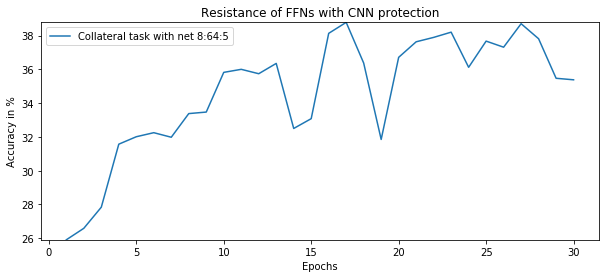

In [129]:
architectures = [[64, 32, 16, 8], [32, 16, 8], [24, 12], [64], [32], [16]]
architectures = [[64]]

for architecture in architectures:
    model = FFNet(architecture, quadratic_model)
    _, test_perfs_font = evaluate_resistance(model)
    
    architecture = ':'.join(map(str, [8] + architecture + [N_FONTS]))
    resistance_reports[f"Collateral task with net {architecture}"] = test_perfs_font
    
show_results(resistance_reports, title="Resistance of FFNs with CNN protection")


## 3.2 Non-DL models

### Data preparation

In [130]:
transform = BaseNet(quadratic_model)

In [131]:
def get_input_onehot_labels(dataset, label="font", one_hot=True):
    data_input = dataset.tensors[0]
    label_idx = {'char': 0, 'font': 1}[label]
    label_size = {'char': 26, 'font': 5}[label]
    labels = dataset.tensors[1][:, label_idx].view(-1, 1)
    
    data_label_onehot = torch.zeros(len(labels), label_size)
    data_label_onehot.scatter_(1, labels, 1)
    
    return data_input, labels, data_label_onehot
    

Get dataset and transform in one hot vector

In [212]:
train_dataset, test_dataset = get_datasets()
train_input, train_label, train_label_one_hot = get_input_onehot_labels(train_dataset, label="font")
test_input, test_label, test_label_one_hot = get_input_onehot_labels(test_dataset, label="font")

Training set 60000 items
Testing set  10000 items


Apply the quadratic model transformation

In [213]:
train_input = transform.quad(train_input)
test_input = transform.quad(test_input)

In [214]:
train_input = train_input.detach().numpy()
test_input = test_input.detach().numpy()

In [265]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
y = train_label.view(-1).detach().numpy()
X = train_input[((y == 3).astype(int) + (y == 1).astype(int)).astype(bool)]

y = y[((y == 3).astype(int) + (y == 1).astype(int)).astype(bool)]
y = ((y - 1)/2).astype(int)
X_r = pca.fit_transform(X)

lda = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda.fit(X, y).transform(X)

In [254]:
X_r2.shape

(24193, 1)

explained variance ratio (first two components): [0.48999688 0.19703138]


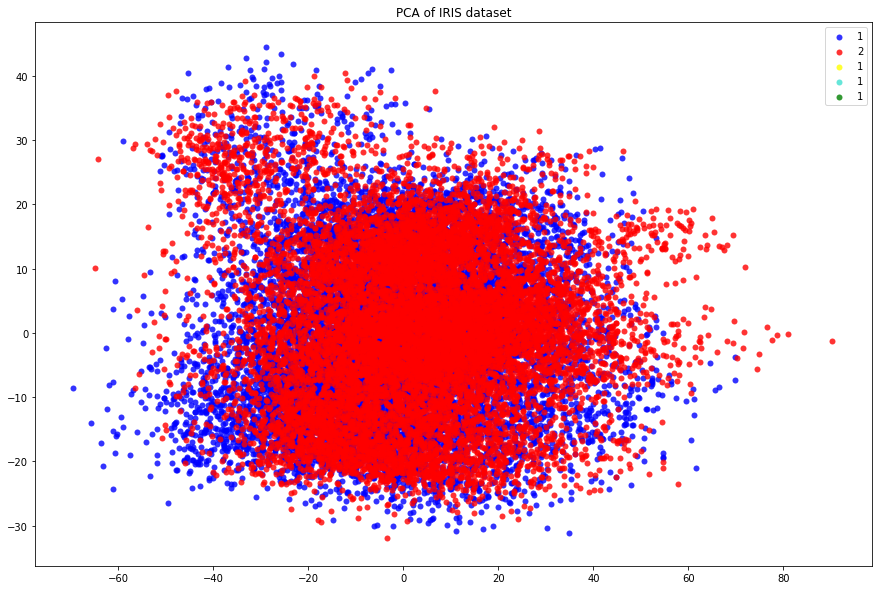

In [259]:
# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

plt.figure(figsize=(15, 10))
colors = ['blue', 'red', 'yellow', 'turquoise', 'green']
lw = 0.001

target_names = ['1', '2', '1', '1', '1']

for color, i, target_name in zip(colors, [0, 1, 2, 3, 4], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of IRIS dataset')


plt.show()


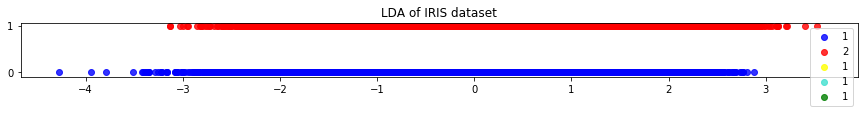

In [262]:
plt.figure(figsize=(15, 1))
for color, i, target_name in zip(colors, [0, 1, 2, 3, 4], target_names):
    plt.scatter(X_r2[y == i, 0], X_r[y == i, 0]*0 + i, alpha=.8, color=color,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('LDA of IRIS dataset')

plt.show()

(24193, 8)
0.5583019881783987


ValueError: X has 2 features per sample; expecting 8

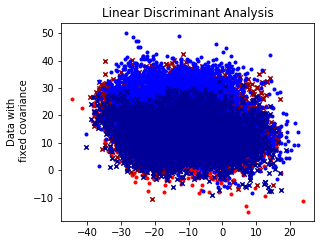

In [273]:
from scipy import linalg
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import colors

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# #############################################################################
# Colormap
cmap = colors.LinearSegmentedColormap(
    'red_blue_classes',
    {'red': [(0, 1, 1), (1, 0.7, 0.7)],
     'green': [(0, 0.7, 0.7), (1, 0.7, 0.7)],
     'blue': [(0, 0.7, 0.7), (1, 1, 1)]})
plt.cm.register_cmap(cmap=cmap)


# #############################################################################
# Generate datasets
def _dataset_fixed_cov():
    '''Generate 2 Gaussians samples with the same covariance matrix'''
    n, dim = 300, 2
    np.random.seed(0)
    C = np.array([[0., -0.23], [0.83, .23]])
    X = np.r_[np.dot(np.random.randn(n, dim), C),
              np.dot(np.random.randn(n, dim), C) + np.array([1, 1])]
    y = np.hstack((np.zeros(n), np.ones(n)))
    return X, y


def _dataset_cov():
    '''Generate 2 Gaussians samples with different covariance matrices'''
    n, dim = 300, 2
    np.random.seed(0)
    C = np.array([[0., -1.], [2.5, .7]]) * 2.
    X = np.r_[np.dot(np.random.randn(n, dim), C),
              np.dot(np.random.randn(n, dim), C.T) + np.array([1, 4])]
    y = np.hstack((np.zeros(n), np.ones(n)))
    return X, y


# #############################################################################
# Plot functions
def plot_data(lda, X, y, y_pred, fig_index):
    splot = plt.subplot(2, 2, fig_index)
    if fig_index == 1:
        plt.title('Linear Discriminant Analysis')
        plt.ylabel('Data with\n fixed covariance')
    elif fig_index == 2:
        plt.title('Quadratic Discriminant Analysis')
    elif fig_index == 3:
        plt.ylabel('Data with\n varying covariances')

    tp = (y == y_pred)  # True Positive
    tp0, tp1 = tp[y == 0], tp[y == 1]
    X0, X1 = X[y == 0], X[y == 1]
    X0_tp, X0_fp = X0[tp0], X0[~tp0]
    X1_tp, X1_fp = X1[tp1], X1[~tp1]

    # class 0: dots
    plt.scatter(X0_tp[:, 0], X0_tp[:, 1], marker='.', color='red')
    plt.scatter(X0_fp[:, 0], X0_fp[:, 1], marker='x',
                s=20, color='#990000')  # dark red

    # class 1: dots
    plt.scatter(X1_tp[:, 0], X1_tp[:, 1], marker='.', color='blue')
    plt.scatter(X1_fp[:, 0], X1_fp[:, 1], marker='x',
                s=20, color='#000099')  # dark blue

    # class 0 and 1 : areas
    nx, ny = 200, 100
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),
                         np.linspace(y_min, y_max, ny))
    Z = lda.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z[:, 1].reshape(xx.shape)
    plt.pcolormesh(xx, yy, Z, cmap='red_blue_classes',
                   norm=colors.Normalize(0., 1.), zorder=0)
    plt.contour(xx, yy, Z, [0.5], linewidths=2., colors='white')

    # means
    plt.plot(lda.means_[0][0], lda.means_[0][1],
             '*', color='yellow', markersize=15, markeredgecolor='grey')
    plt.plot(lda.means_[1][0], lda.means_[1][1],
             '*', color='yellow', markersize=15, markeredgecolor='grey')

    return splot


def plot_ellipse(splot, mean, cov, color):
    v, w = linalg.eigh(cov)
    u = w[0] / linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    # filled Gaussian at 2 standard deviation
    ell = mpl.patches.Ellipse(mean, 2 * v[0] ** 0.5, 2 * v[1] ** 0.5,
                              180 + angle, facecolor=color,
                              edgecolor='black', linewidth=2)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(0.2)
    splot.add_artist(ell)
    splot.set_xticks(())
    splot.set_yticks(())


def plot_lda_cov(lda, splot):
    plot_ellipse(splot, lda.means_[0], lda.covariance_, 'red')
    plot_ellipse(splot, lda.means_[1], lda.covariance_, 'blue')


def plot_qda_cov(qda, splot):
    plot_ellipse(splot, qda.means_[0], qda.covariance_[0], 'red')
    plot_ellipse(splot, qda.means_[1], qda.covariance_[1], 'blue')


plt.figure(figsize=(10, 8), facecolor='white')
# Linear Discriminant Analysis
lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True, n_components=2)
print(X.shape)
y_pred = lda.fit(X, y).predict(X)
print((y_pred == y).sum()/len(y))
splot = plot_data(lda, X, y, y_pred, fig_index=1)
plot_lda_cov(lda, splot)
plt.axis('tight')

# Quadratic Discriminant Analysis
qda = QuadraticDiscriminantAnalysis(store_covariance=True, n_components=2)
y_pred = qda.fit(X, y).predict(X)
splot = plot_data(qda, X, y, y_pred, fig_index=2)
plot_qda_cov(qda, splot)
plt.axis('tight')
plt.suptitle('Linear Discriminant Analysis vs Quadratic Discriminant Analysis',
             y=1.02, fontsize=15)
plt.tight_layout()
plt.show()

Convert to numpy

In [143]:
train_input = train_input.detach().numpy()
test_input = test_input.detach().numpy()

In [134]:
train_input.shape, train_label.shape

((60000, 8), torch.Size([60000, 1]))

In [135]:
ALL = train_input.shape[0]
CPOWER = 'LOW'

In [136]:
from sklearn import linear_model
from sklearn import kernel_ridge
from sklearn import svm

In [137]:
def evaluate_sklearn(reg, one_hot=True, limit=int(10e10)):
    train_labels = {True: train_label_one_hot, False: train_label}[one_hot]
    reg.fit(train_input[:limit], train_labels[:limit].detach().numpy()) 
    output = reg.predict(test_input)
    if one_hot:
        pred = torch.tensor(output).argmax(1, keepdim=True)
    else:
        if isinstance(output, list):
            pred = torch.tensor(list(map(round, output))).long().view(-1, 1)
        else:
            pred = torch.tensor(np.round(output)).long().view(-1, 1)
    y = test_label.view_as(pred)
    acc = pred.eq(y).sum().item() / len(pred)
    return acc

### K-Neighbors Classifier

In [138]:
from sklearn.neighbors import KNeighborsClassifier

In [139]:

clf = KNeighborsClassifier(n_neighbors=7)
acc = evaluate_sklearn(clf, one_hot=False)
print(acc)
resistance_reports['K-Neighbors Classifier'] = acc * 100

/Users/tryffel/code/env/pysyft/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


0.5675


### Ensemble methods

In [76]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [77]:

clf = RandomForestClassifier(max_depth=30, n_estimators=100, max_features=4)
acc = evaluate_sklearn(clf, one_hot=False)
print(acc)
resistance_reports['Random Forest Classifier'] = acc * 100

/Users/tryffel/code/env/pysyft/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


0.4096


In [78]:

clf = GradientBoostingClassifier(n_estimators=10, learning_rate=1.0,
    max_depth=10, random_state=0)
acc = evaluate_sklearn(clf, one_hot=False)
print(acc)
resistance_reports['Gradient Boosting Classifier'] = acc * 100

/Users/tryffel/code/env/pysyft/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.3198


## Summary

In [36]:
def print_table(results):
    n_cols = 2
    title_length = 0
    for title in results.keys():
        title_length = max(title_length, len(title))
    result_length = 8
    table_length = 1 + n_cols + title_length + result_length
    sep = '+'.join(
        ['', '-'*title_length, '-'*result_length, '']
    )
    for title, serie in results.items():
        print(sep)
        title = (title + ' '*title_length)[:title_length]
        if isinstance(serie, list):
            result = round(np.mean(serie[-4:]), 2)
        else:
            result = round(serie, 2)
        result = (' ' +str(result) + '%' + ' '*result_length)[:result_length]
        line = '|'.join(
            ['', title, result, '']
        )
        print(line)
    print(sep)

In [37]:
print_table(resistance_reports)

+----------------------------+--------+
|K-Neighbors Classifier      | 56.78% |
+----------------------------+--------+
|Random Forest Classifier    | 57.94% |
+----------------------------+--------+
|Gradient Boosting Classifier| 44.63% |
+----------------------------+--------+


### Compative results

+---------------------------------------+--------+--------+
| Model                                 | Basic  |Resisted| 
+---------------------------------------+--------+--------+
|Collateral task with net 8:64:32:16:8:5| 49.1%  | 29.5%  |
+---------------------------------------+--------+--------+
|Collateral task with net 8:32:16:8:5   | 47.76% | 25.46% |
+---------------------------------------+--------+--------+
|Collateral task with net 8:24:12:5     | 46.4%  | 24.26% |
+---------------------------------------+--------+--------+
|Collateral task with net 8:64:5        | 52.29% | 31.34% |
+---------------------------------------+--------+--------+
|Collateral task with net 8:32:5        | 48.47% | 28.37% |
+---------------------------------------+--------+--------+
|Collateral task with net 8:16:5        | 41.96% | 26.88% |
+---------------------------------------+--------+--------+
|linear model Ridge                     | 31.75% | 26.39% |
+---------------------------------------+--------+--------+
|linear model Lasso                     | 30.82% | 25.36% |
+---------------------------------------+--------+--------+
|logistic regression                    | 32.08% | 26.15% |
+---------------------------------------+--------+--------+
|Quadratic Discriminant Analysis        | 40.62% | 30.19% |
+---------------------------------------+--------+--------+
|SVM (rbf)                              | 51.14% | 28.59% |
+---------------------------------------+--------+--------+
|SGDClassifier                          | 25.79% | 24.69% |
+---------------------------------------+--------+--------+
|K-Neighbors Classifier                 | 70.04% | 56.75% | *
+---------------------------------------+--------+--------+
|Gaussian process                       | 21.24% | 20.39% |
+---------------------------------------+--------+--------+
|Decision Tree Classifier               | 37.04% | 28.48% |
+---------------------------------------+--------+--------+
|Random Forest Classifier               | 69.5%  | 55.87% | *
+---------------------------------------+--------+--------+
|AdaBoost Classifier                    | 37.34% | 28.69% |
+---------------------------------------+--------+--------+
|Gradient Boosting Classifier           | 60.07% | 45.02% | *
+---------------------------------------+--------+--------+
|Collateral task with CNN 0             |        | 45.7%  | *
+---------------------------------------+--------+--------+
|Collateral task with CNN 1             |        | 45.5%  | *
+---------------------------------------+--------+--------+


## Conclusion
Overall, the models which use linear components behave quite poorly, while those based on completely different learning approaches (like K-Neighbors Classifier or Random Forest Classifier for example) manage to keep a pretty good accuracy in general. They also suffer from substantial accuracy drop in the sabotage setting (-15pt, while others loose more than 20pt), but as their initial performance was really good, they stand as outliers and robust adversaries which can help disclosing meaningful and sensitive information. For example, the K-Neighbors Classifier  succeeds in its predictions almost 3 times out of 5.